In [1]:
from google.colab import drive
drive.mount('/content/drive/')

MessageError: ignored

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 24.5 MB/s 
     |████████████████████████████████| 3.3 MB 67.7 MB/s 
     |████████████████████████████████| 596 kB 51.2 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 895 kB 47.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from distutils.version import LooseVersion as LV

from sklearn.model_selection import train_test_split

import io

In [ ]:
import pandas as pd
import spacy
import re
import requests, json 
import plac
import random
from spacy.util import minibatch, compounding
import seaborn as sns 
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.10.0+cu111 Device: cpu 


In [ ]:
df1 = pd.read_csv('drive/MyDrive/Text Analytics/Sentences_AllAgree.txt',
                 names=['News','Sentiment'], encoding = "ISO-8859-1",header=None,sep='@')

In [ ]:
df1

,News,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive
...,...,...
2259,Operating result for the 12-month period decre...,negative
2260,HELSINKI Thomson Financial - Shares in Cargote...,negative
2261,LONDON MarketWatch -- Share prices ended lower...,negative
2262,Operating profit fell to EUR 35.4 mn from EUR ...,negative


In [ ]:
df2 = pd.read_csv('drive/MyDrive/Text Analytics/Sentences_50Agree.txt',
                 names=['News','Sentiment'], encoding = "ISO-8859-1",header=None,sep='@')

In [ ]:
df2

,News,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,negative
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
4843,Operating profit fell to EUR 35.4 mn from EUR ...,negative
4844,Net sales of the Paper segment decreased to EU...,negative


In [ ]:
df3 = pd.concat([df1, df2]).drop_duplicates(keep=False)

In [ ]:
df3.to_csv('drive/MyDrive/Text Analytics/Sentences_Merge.csv', index=False)

NameError: ignored

In [ ]:
df3

,News,Sentiment
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive
5,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive
...,...,...
4829,The OMX Helsinki index was 0.33 pct lower at 9...,negative
4834,Hobby Hall 's sales decrease 26 pct due to imp...,negative
4838,The company said that its comparable operating...,negative
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral


In [ ]:
# prendere il 30% del file tenendo bilanciate le percentuali di Sentiment
test_data = pd.read_csv('drive/MyDrive/Text Analytics/Sentences_Merge.csv')

test_data

,News,Sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive
...,...,...
2575,The OMX Helsinki index was 0.33 pct lower at 9...,negative
2576,Hobby Hall 's sales decrease 26 pct due to imp...,negative
2577,The company said that its comparable operating...,negative
2578,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral


In [ ]:
test_data['News'] = test_data['News'].str.replace('"', '')

In [ ]:
test_data.head()

,News,Sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive


In [ ]:
dataframe_positive = test_data[['News','Sentiment']][test_data['Sentiment']=='positive'].copy()

In [ ]:
dataframe_positive

,News,Sentiment
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive
5,TeliaSonera TLSN said the offer is in line wit...,positive
6,"STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMEN...",positive
...,...,...
2546,"According to the company , its operating profi...",positive
2547,"The apartment block will be well-located , in ...",positive
2552,"The antibody , given at repeated doses of up t...",positive
2555,Our superior customer centricity and expertise...,positive


In [ ]:
dataframe_positive1 = dataframe_positive.sample(n = 645)

In [ ]:
dataframe_positive1

,News,Sentiment
1083,Higher bit rates for outgoing traffic improves...,positive
713,NASDAQ-listed Yahoo Inc has introduced a new s...,positive
643,Atria will launch a campaign in September to p...,positive
91,The company expects its net sales in the first...,positive
207,Componenta increased its stake in Turkish stee...,positive
...,...,...
659,Employees are also better prepared to answer c...,positive
1288,Finnish-owned contract manufacturer of electro...,positive
1170,18 May 2010 - Finnish electronics producer Elc...,positive
399,All of Raisio 's divisions recorded an operati...,positive


In [ ]:
dataframe_positive1.to_csv('drive/MyDrive/Text Analytics/positive_dataframe.csv')

In [ ]:
with open("drive/MyDrive/Text Analytics/Sentences_Merge.csv",encoding = "ISO-8859-1",newline='') as file_1,\
  open("drive/MyDrive/Text Analytics/positive_dataframe.csv",encoding = "ISO-8859-1",newline='') as file_2:
  with open("drive/MyDrive/Text Analytics/test_set_finale.txt", "w") as output: 
    next(file_1)
    next(file_2)
    for line in file_1:
      word = line.split('.",')
      print(word)
      if word:
        news = word[0]
        sentiment = word[1]
      print(line)
      for line1 in file_2:
        word1 = line1.split(',')
        news1 = word1[0]
        sentiment1 = word1[1]
        print(line1)
        if line == line1 and sentiment1 == 'positive':
          output.write(line1)
        else:
          output.write(line1)

file_1.close()
file_2.close()

['"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ', 'neutral\n']
"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",neutral

1083,"Higher bit rates for outgoing traffic improves the end-user experience of mobile broadband services such as video conferencing , file sharing and sending e-mails with attachments .",positive

713,NASDAQ-listed Yahoo Inc has introduced a new service that enables Malaysians to take their favorite Internet content and services with them on their mobile phones .,positive

643,"Atria will launch a campaign in September to promote the CampoMos brand on the Moscow market , he said .",positive

91,The company expects its net sales in the first half of 2008 to reach the previous year 's

IndexError: ignored

In [ ]:
int_df

,News,Sentiment_x,Sentiment_y
0,Technopolis plans to develop in stages an area...,neutral,NaN
1,The international electronic industry company ...,negative,NaN
2,With the new production plant the company woul...,positive,positive
3,According to the company 's updated strategy f...,positive,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive,positive
...,...,...,...
2575,The OMX Helsinki index was 0.33 pct lower at 9...,negative,NaN
2576,Hobby Hall 's sales decrease 26 pct due to imp...,negative,NaN
2577,The company said that its comparable operating...,negative,NaN
2578,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral,NaN


In [ ]:
test_data.head()

,News,Sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive
5,TeliaSonera TLSN said the offer is in line wit...,positive
6,"STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMEN...",positive
21,"In Sweden , Gallerix accumulated SEK denominat...",neutral
22,The company supports its global customers in d...,neutral
23,"When this investment is in place , Atria plans...",neutral


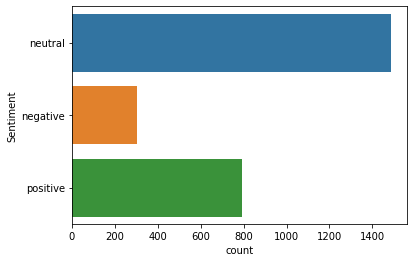

In [ ]:
#dopo la pulizia il dataset risulta avere la stessa composizone (più o meno) del dataset originale
sns.countplot(y="Sentiment",data=test_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


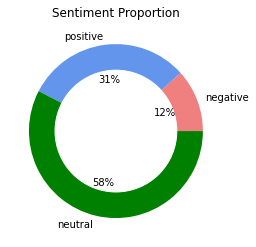

In [ ]:
Y_count = len(test_data[test_data['Sentiment'] == 'negative'])
N_count = len(test_data[test_data['Sentiment'] == 'positive'])
Z_count = len(test_data[test_data['Sentiment'] == 'neutral'])

# create data
names='negative', 'positive','neutral',
size=[Y_count,N_count,Z_count]

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['lightcoral','cornflowerblue','green'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
ax = plt.axes()
ax.set_title("Sentiment Proportion")
plt.show()

In [ ]:
training_data = pd.read_csv('drive/MyDrive/Text Analytics/Sentences_AllAgree.txt',
                 names=['News','Sentiment'], encoding = "ISO-8859-1",header=None,sep='@')

In [ ]:
training_data

,News,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive
...,...,...
2259,Operating result for the 12-month period decre...,negative
2260,HELSINKI Thomson Financial - Shares in Cargote...,negative
2261,LONDON MarketWatch -- Share prices ended lower...,negative
2262,Operating profit fell to EUR 35.4 mn from EUR ...,negative


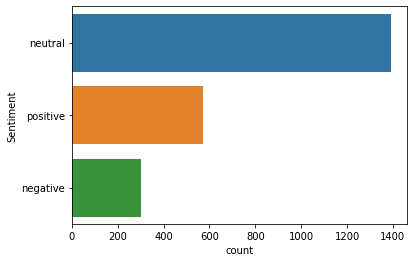

In [ ]:
#dopo la pulizia il dataset risulta avere la stessa composizone (più o meno) del dataset originale
sns.countplot(y="Sentiment",data=training_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


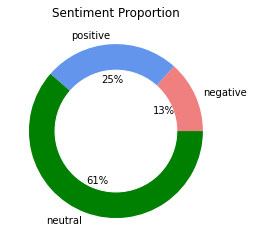

In [ ]:
Y_count = len(training_data[training_data['Sentiment'] == 'negative'])
N_count = len(training_data[training_data['Sentiment'] == 'positive'])
Z_count = len(training_data[training_data['Sentiment'] == 'neutral'])

# create data
names='negative', 'positive','neutral',
size=[Y_count,N_count,Z_count]

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['lightcoral','cornflowerblue','green'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
ax = plt.axes()
ax.set_title("Sentiment Proportion")
plt.show()

In [ ]:
df4 = pd.read_csv('drive/MyDrive/Text Analytics/Sentences_75Agree.txt',
                 names=['News','Sentiment'], encoding = "ISO-8859-1",header=None,sep='@')

In [ ]:
validation_data = pd.concat([df4, df1]).drop_duplicates(keep=False)

In [ ]:
validation_data

,News,Sentiment
1,With the new production plant the company woul...,positive
6,TeliaSonera TLSN said the offer is in line wit...,positive
7,"STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMEN...",positive
8,"A purchase agreement for 7,200 tons of gasolin...",positive
14,Incap Contract Manufacturing Services Pvt Ltd ...,positive
...,...,...
3429,Operating profit excluding non-recurring items...,negative
3432,"Nevertheless , the development can not be allo...",neutral
3435,It holds 38 percent of Outokumpu 's shares and...,neutral
3439,The OMX Helsinki index was 0.33 pct lower at 9...,negative


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


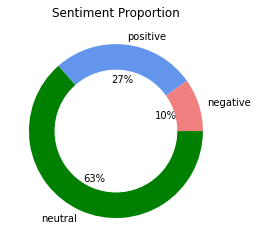

In [ ]:
Y_count = len(validation_data[validation_data['Sentiment'] == 'negative'])
N_count = len(validation_data[validation_data['Sentiment'] == 'positive'])
Z_count = len(validation_data[validation_data['Sentiment'] == 'neutral'])

# create data
names='negative', 'positive','neutral',
size=[Y_count,N_count,Z_count]

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['lightcoral','cornflowerblue','green'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
ax = plt.axes()
ax.set_title("Sentiment Proportion")
plt.show()

In [ ]:
test_data = pd.concat([df3, validation_data]).drop_duplicates(keep=False)

In [ ]:
test_data

,News,Sentiment
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
4,According to the company 's updated strategy f...,positive
5,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive
21,( Filippova ) A trilateral agreement on invest...,positive
...,...,...
4825,have notified that as a result of the Company ...,negative
4834,Hobby Hall 's sales decrease 26 pct due to imp...,negative
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
4844,Net sales of the Paper segment decreased to EU...,negative


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


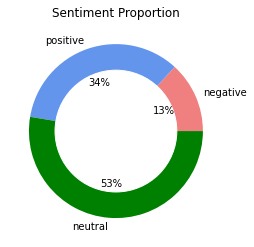

In [ ]:
Y_count = len(test_data[test_data['Sentiment'] == 'negative'])
N_count = len(test_data[test_data['Sentiment'] == 'positive'])
Z_count = len(test_data[test_data['Sentiment'] == 'neutral'])

# create data
names='negative', 'positive','neutral',
size=[Y_count,N_count,Z_count]

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['lightcoral','cornflowerblue','green'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
ax = plt.axes()
ax.set_title("Sentiment Proportion")
plt.show()
#da modificare perché sproporzionato rispetto a validation and training 

In [ ]:
import csv
x_train = list()
y_train = list()
delimiter = '@'
with open('drive/MyDrive/Text Analytics/Sentences_AllAgree.txt', encoding = "ISO-8859-1",newline='') as infile:
    reader = csv.reader(infile, delimiter=delimiter)
    for row in reader:
        x_train.append(row[0])
        y_train.append(row[1])

x_test = list()
y_test = list()
with open('drive/MyDrive/Text Analytics/Sentences_Merge.txt', encoding = "ISO-8859-1",newline='') as infile:
    reader = csv.reader(infile, delimiter=delimiter)
    for row in reader:
      if row:
        x_test.append(row[0])
        y_test.append(row[1])

In [ ]:
len(x_train),len(y_train),len(x_test),len(y_test)

(2264, 2264, 2263, 2263)

In [ ]:
set(y_train)

{'negative', 'neutral', 'positive'}

In [ ]:
sample_idx = 10
x_train[sample_idx]

'Its board of directors will propose a dividend of EUR0 .12 per share for 2010 , up from the EUR0 .08 per share paid in 2009 .'

In [ ]:
import numpy as np

# numpy implements many useful and powerful vector manipulation tools
# here I'm using it to quickly create a True,False vector corresponding
# to the original values being equal to our label of interest or not
# i.e., binary labels

y_train_bin = np.asarray(y_train)==y_train[sample_idx]
y_test_bin = np.asarray(y_test)==y_train[sample_idx]
y_train_bin,y_test_bin

(array([False,  True,  True, ..., False, False, False]),
 array([ True,  True,  True, ..., False, False, False]))

In [ ]:
sentences_train = ["[CLS] " + s for s in x_train]
sentences_test = ["[CLS] " + s for s in x_test]
labels_train = [1 if value else 0 for value in y_train_bin]
labels_test  = [1 if value else 0 for value in y_test_bin]

In [ ]:
BERTMODEL = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(BERTMODEL,
                                          do_lower_case=True)
tokenizer

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
from tqdm import tqdm

tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(sentences_test)]

100%|██████████| 2263/2263 [00:01<00:00, 1385.19it/s]


In [ ]:
print ("The full tokenized first training sentence:")
print (tokenized_train[0])

The full tokenized first training sentence:
['[CLS]', 'according', 'to', 'gran', ',', 'the', 'company', 'has', 'no', 'plans', 'to', 'move', 'all', 'production', 'to', 'russia', ',', 'although', 'that', 'is', 'where', 'the', 'company', 'is', 'growing', '.']


In [ ]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 512

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test]

print ("The truncated tokenized first training sentence:")
print (tokenized_train[0])

The truncated tokenized first training sentence:
['[CLS]', 'according', 'to', 'gran', ',', 'the', 'company', 'has', 'no', 'plans', 'to', 'move', 'all', 'production', 'to', 'russia', ',', 'although', 'that', 'is', 'where', 'the', 'company', 'is', 'growing', '.', 'SEP']


In [ ]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test])

print ("The indices of the first training sentence:")
print (ids_train[0])

The indices of the first training sentence:
[  101  2429  2000 12604  1010  1996  2194  2038  2053  3488  2000  2693
  2035  2537  2000  3607  1010  2348  2008  2003  2073  1996  2194  2003
  3652  1012   100     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [ ]:
amasks_train, amasks_test = [], []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)

for seq in ids_test:
  seq_mask = [float(i>0) for i in seq]
  amasks_test.append(seq_mask)

In [ ]:
amasks_test

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(labels_test)
test_masks  = torch.tensor(amasks_test)

In [ ]:
BATCH_SIZE = 32

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'documents')

Datasets:
Train: 2037 documents
Validation: 227 documents
Test: 2263 documents


In [ ]:
model = BertForSequenceClassification.from_pretrained(BERTMODEL,
                                                      num_labels=2)
model.cuda()
print('Pretrained BERT model "{}" loaded'.format(BERTMODEL))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

RuntimeError: ignored

In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
EPOCHS = 4
WEIGHT_DECAY = 0.01
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

In [ ]:
def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)

    loss = outputs[0]
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

def evaluate(loader):
  model.eval()

  n_correct, n_all = 0, 0

  for batch in loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
      logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    labels = b_labels.to('cpu').numpy()
    n_correct += np.sum(predictions == labels)
    n_all += len(labels)

  print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))

In [ ]:
train_lossv = []
for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader)


Train Epoch: 1 [0/2037 (0%)]	Loss: 0.727639

Validation set:
Accuracy: [190/227] 0.8370

Train Epoch: 2 [0/2037 (0%)]	Loss: 0.222876

Validation set:
Accuracy: [210/227] 0.9251

Train Epoch: 3 [0/2037 (0%)]	Loss: 0.114637

Validation set:
Accuracy: [219/227] 0.9648

Train Epoch: 4 [0/2037 (0%)]	Loss: 0.177649

Validation set:
Accuracy: [219/227] 0.9648


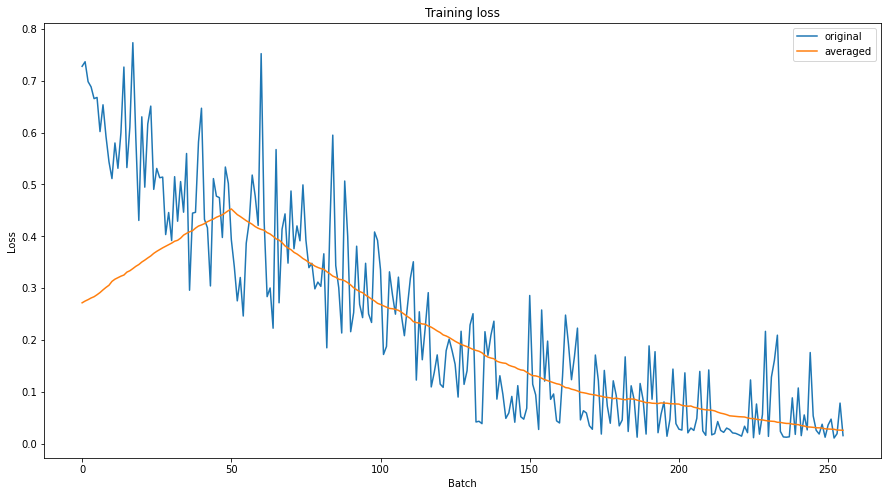

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()

In [ ]:
print('Test set:')
evaluate(test_dataloader)

Test set:
Accuracy: [2232/2263] 0.9863


In [ ]:
def create_bert_data():
  bert_data = pd.DataFrame()
  tok = []
  words = []
  sentence_num = []
  for ind in data.index:
    for word in data['Headline'].iloc[ind].split():
      startup_name = data['Startup'].iloc[ind].split()
      if len(startup_name) > 1:
        if word in startup_name:
            if word == startup_name[0] :
              tok.append("B-ORG")
            elif word in startup_name:
              tok.append("I-ORG")
        else:
          tok.append("O")   
      elif word == startup_name[0]:
          tok.append("B-ORG")
      else:
          tok.append("O")
      words.append(word)
      sentence_num.append(ind)
  bert_data['words'] = words
  bert_data['sentence_id'] = sentence_num
  bert_data['labels'] = tok
  return bert_data

In [ ]:
bert_data = create_bert_data()
bert_data.head()